# STAT4012 Group Project
- The file is used to test the code for the project.  
- It should be written with **clear comments** and **explanations** on each sections of the code.  
- If there are some other modules that need to be imported or run in this file, you can use %load filename.py to load the code from the file. use %run filename.py to run the code from the file.  

In [15]:
# import libraries
# all the libraries are imported here but not below
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


In [14]:
data = pd.read_excel('../data/raw_data_adjusted.xlsx',
                     index_col=0).dropna(how='any')
data.sort_values(by='date', ascending=True, inplace=True)


## 1.Preprocessing

### 1.1 calculate 6th day's intraday return -> label

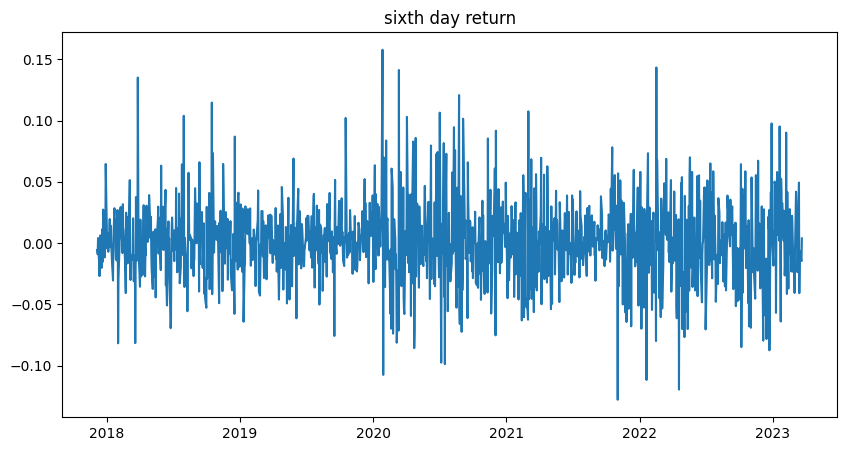

In [13]:
data['sixth_day_return'] = (
    (data['close'].shift(-5)-data['open'].shift(-5))/data['open'].shift(-5)).dropna(how='any')

# plot sixth day return
plt.figure(figsize=(10, 5))
plt.plot(data['sixth_day_return'])
plt.title('sixth day return')
plt.show()


### 1.2 mark golden cross point and death cross point

            golden_cross  death_cross
date                                 
2017-12-06           0.0          0.0
2017-12-07           0.0          0.0
2017-12-08           0.0          0.0
2017-12-11           0.0          0.0
2017-12-12           1.0          0.0
...                  ...          ...
2023-04-06           1.0          0.0
2023-04-10           0.0          1.0
2023-04-11           0.0          0.0
2023-04-12           0.0          0.0
2023-04-13           0.0          0.0

[1346 rows x 2 columns]
golden_cross    76.0
death_cross     76.0
dtype: float64


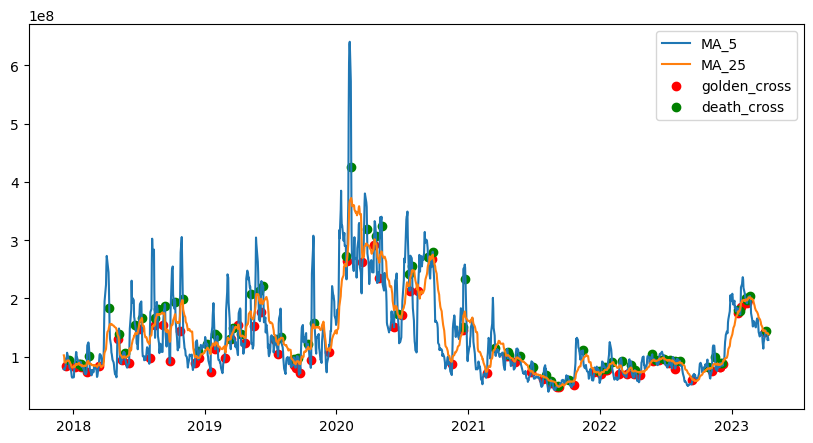

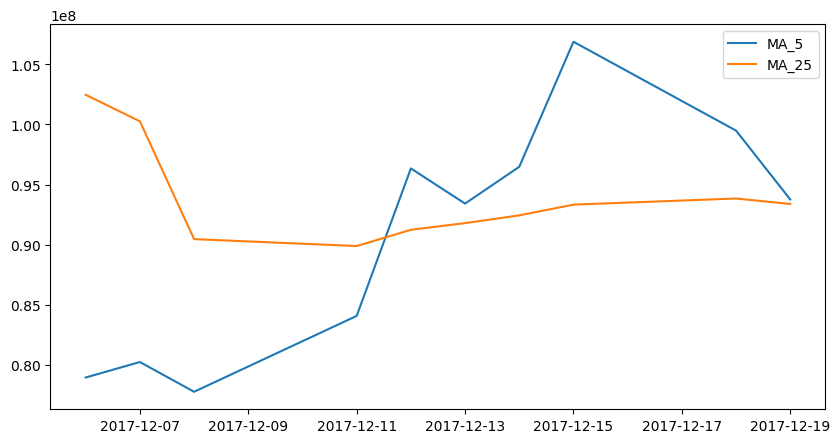

In [21]:
data['diff'] = np.sign(data["MA_5"] - data["MA_25"])
data['signal'] = np.sign(data['diff'] - data['diff'].shift(1))
data['golden_cross'] = data['signal'].map({1: 1, 0: 0, -1: 0})
data['death_cross'] = data['signal'].map({-1: 1, 0: 0, 1: 0})
data = data.drop(columns=['diff', 'signal']).dropna(how='any')
print(data[['golden_cross', 'death_cross']])
print(data[['golden_cross', 'death_cross']].sum())

# plot MA_5 and MA_25 and make golden cross point to be red and death cross point to be green
plt.figure(figsize=(10, 5))
plt.plot(data['MA_5'], label='MA_5')
plt.plot(data['MA_25'], label='MA_25')
plt.scatter(data[data['golden_cross'] == 1].index,
            data[data['golden_cross'] == 1]['MA_5'], c='r', label='golden_cross')
plt.scatter(data[data['death_cross'] == 1].index,
            data[data['death_cross'] == 1]['MA_5'], c='g', label='death_cross')
plt.legend()
plt.show()

# plot MA_5 and MA_25 with golden cross point and death cross point for first 100 day
plt.figure(figsize=(10, 5))
plt.plot(data['MA_5'][:10], label='MA_5')
plt.plot(data['MA_25'][:10], label='MA_25')
plt.scatter(data[data['golden_cross'] == 1].index[:6],
            data[data['golden_cross'] == 1]['MA_5'][:6], c='r', label='golden_cross')
plt.scatter(data[data['death_cross'] == 1].index[:6],
            data[data['death_cross'] == 1]['MA_5'][:6], c='g', label='death_cross')
plt.legend()
plt.show()


### 1.3 feature scaling: use normalization as extreme values are rare

In [48]:
data = data.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
print(data.head)


<bound method NDFrame.head of                 open     close      high       low  daily_trading_value  \
date                                                                      
2017-11-29  0.022734  0.021534  0.021775  0.021029             0.013371   
2017-11-30  0.021276  0.021753  0.020565  0.021589             0.004283   
2017-12-01  0.020755  0.021365  0.020502  0.021675             0.004137   
2017-12-04  0.020932  0.021142  0.020161  0.020924             0.007211   
2017-12-05  0.020180  0.020891  0.020117  0.020990             0.004788   
...              ...       ...       ...       ...                  ...   
2023-03-30  0.459460  0.460630  0.459853  0.463660             0.139262   
2023-03-31  0.464342  0.491230  0.485870  0.470718             0.226156   
2023-04-03  0.470301  0.459349  0.473184  0.458024             0.215995   
2023-04-04  0.463816  0.453847  0.463372  0.453250             0.157554   
2023-04-05  0.446778  0.436110  0.443313  0.436595             0.16119

## 2.Feature Engineering

### PCA 

## 3. Build Model

### 3.0 hyperparameter tuning

### 3.1 Convolutional layer & MLP  （实验组）

In [19]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [123]:
# choose a number of time steps
n_steps = 5
# convert into input/output
X, y = split_sequences(data.to_numpy(), n_steps)
print(X.shape, y.shape)


(1342, 5, 20) (1342,)


In [124]:
# split for training set and testing set
X_train, X_test = X[:1000, :, :], X[1000:, :, :]
y_train, y_test = y[:1000], y[1000:]


In [26]:
n_features = X.shape[2]
n_features


20

In [27]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu',
          input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [35]:
# fit model
model.fit(X_train, y_train, epochs=1000, verbose=1)


In [43]:
# demonstrate prediction
y_pred = model.predict(X_test, verbose=1)


11/11 [==============================] - 0s 2ms/step


#### Model evaluation

In [42]:
from keras import losses
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
model.evaluate(X_test, y_test)


11/11 [==============================] - 0s 1ms/step - loss: 7.6684e-09 - accuracy: 0.9415


[7.668434776064714e-09, 0.9415204524993896]

### 3.2 Attention-based LSTM model （实验组）
structure: data -> LSTM layer -> Attention layer -> Dense layer -> prediction

In [86]:
from attention import Attention
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model, Model


In [125]:
time_steps = 5
input_dim = 20

# Define/compile the model.
model_input = Input(shape=(time_steps, input_dim))
x = LSTM(64, return_sequences=True)(model_input)
x = Attention(units=32)(x)
x = Dense(1)(x)
Attention_model = Model(model_input, x)
Attention_model.compile(loss='mae', optimizer='adam')
Attention_model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 5, 20)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 5, 64)             21760     
                                                                 
 attention_2 (Attention)     (None, 32)                8192      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,985
Trainable params: 29,985
Non-trainable params: 0
_________________________________________________________________


In [126]:
# train.
Attention_model.fit(X_train, y_train, epochs=10)


Epoch 1/10
32/32 [==============================] - 3s 9ms/step - loss: 0.0772
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0602
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0582
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0583
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0575
Epoch 6/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0578
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0566
Epoch 8/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0572
Epoch 9/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0586
Epoch 10/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0569


In [127]:
Attention_model.compile(loss='categorical_crossentropy',
                        optimizer='sgd',
                        metrics=['accuracy'])
Attention_model.evaluate(X_test, y_test)


11/11 [==============================] - 1s 4ms/step - loss: 7.6684e-09 - accuracy: 0.9357


[7.668434776064714e-09, 0.9356725215911865]

### 3.3 Simple LSTM （对照组1）

In [128]:
time_steps = 5
input_dim = 20

# Define/compile the model.
model_input = Input(shape=(time_steps, input_dim))
x = LSTM(64, return_sequences=True)(model_input)
x = Dense(1)(x)
LSTM_model = Model(model_input, x)
LSTM_model.compile(loss='mae', optimizer='adam')
LSTM_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 5, 20)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 64)             21760     
                                                                 
 dense_9 (Dense)             (None, 5, 1)              65        
                                                                 
Total params: 21,825
Trainable params: 21,825
Non-trainable params: 0
_________________________________________________________________


In [129]:
# train.
LSTM_model.fit(X_train, y_train, epochs=10)


Epoch 1/10
32/32 [==============================] - 3s 5ms/step - loss: 0.0710
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0584
Epoch 3/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0565
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0560
Epoch 5/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0561
Epoch 6/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0547
Epoch 7/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0555
Epoch 8/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0579
Epoch 9/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0563
Epoch 10/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0544


In [131]:
LSTM_model.compile(loss='categorical_crossentropy',
                   optimizer='sgd',
                   metrics=['accuracy'])


需要evaluations

### 3.4 ARIMA model（对照组2）

In [49]:
y_train = data['sixth_day_return'].iloc[:1000]
y_test = data['sixth_day_return'].iloc[1000:]


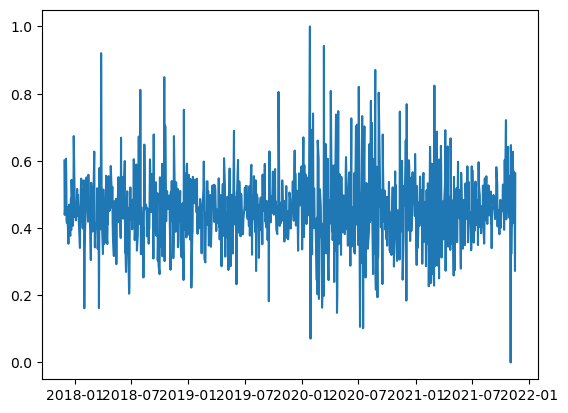

In [50]:
# check stationary
plt.plot(y_train)   # looks good


In [51]:
# ADF test
from statsmodels.tsa.stattools import adfuller
result = adfuller(y_train)
print(result)  # p-value = 2e-30 -> stationary


(-18.365401616832568, 2.2232380434515225e-30, 2, 997, {'1%': -3.4369259442540416, '5%': -2.8644432969122833, '10%': -2.5683158550174094}, -1575.5132998572062)


In [52]:
from pmdarima.arima import auto_arima

model = auto_arima(y_train, trace=True,
                   error_action='ignore', suppress_warnings=True)
print(model.aic())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1619.715, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1607.259, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1612.583, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1613.815, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1311.748, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1616.758, Time=0.90 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1618.642, Time=1.10 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-1617.666, Time=1.28 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-1617.763, Time=1.57 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1613.411, Time=0.79 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-1617.041, Time=1.36 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-1618.518, Time=1.78 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-1615.710, Time=1.84 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=2.51 sec

Best model:  ARIMA(2,0,2)

In [71]:
model.fit(y_train)

y_pred = model.predict(n_periods=len(y_test))
forecast = pd.DataFrame(
    y_pred.values, index=y_test.index, columns=['Prediction'])
print(forecast)


                     Prediction
date                           
2021-11-18 00:00:00    0.457073
2021-11-19 00:00:00    0.428441
2021-11-22 00:00:00    0.464857
2021-11-23 00:00:00    0.457904
2021-11-24 00:00:00    0.444750
...                         ...
2023-03-31 00:00:00    0.453019
2023-04-03 00:00:00    0.453019
2023-04-04 00:00:00    0.453019
2023-04-05 00:00:00    0.453019
y_pred                 0.453019

[347 rows x 1 columns]


c:\Users\Daphne\CloudMusic\123\envs\pandasLearning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [ ]:
# plot the predictions for validation set
plt.plot(y_train, label='Train', color='blue')
plt.plot(y_test, label='Valid', color='black')
plt.plot(forecast, label='Prediction', color='red')
plt.show()


In [ ]:
# evaluate the model


## 4. Model Evaluation

### 4.1 MSE, scores
### 4.2 Back-testing

In [ ]:
import backtrader as bt
import datetime


class Backtest(bt.Strategy):
    params = (("printlog", True), ("quantity", 20000))

    def log(self, txt, dt=None, doprint=False):
        """Logging function for strategy"""
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f"{dt.isoformat()}, {txt}")

    def __init__(self):
        self.dataopen = self.datas[0].open
        self.dataclose = self.datas[0].close
        self.order = 0
        self.open = 1

    def next(self):

        if self.order == 1:
            if self.open == 1:
                self.log('Open, %.2f' % self.dataopen[0])
                self.buy(size=self.params.quantity, exectype=bt.Order.Market)
                self.open = 0
            else:
                self.log('Close, %2f' % self.dataclose[0])
                self.close()
                self.open = 1

        if self.order == -1:
            if self.open == 1:
                self.log('Open, %.2f' % self.dataopen[0])
                self.buy(size=self.params.quantity, exectype=bt.Order.Market)
                self.open = 0
            else:
                self.log('Close, %2f' % self.dataclose[0])
                self.close()
                self.open = 1


if __name__ == "__main__":

    # Read data
    newdata = data.reset_index()
    array1 = np.repeat(newdata.values, 2, axis=0)
    for i in range(len(newdata.index)):
        array1[2*i+1][0] += datetime.timedelta(hours=14)
    newdata = pd.DataFrame(array1)
    newdata.columns = data.reset_index().columns
    newdata.set_index('date')
    newdata = newdata[['open', 'close', 'sixth_day_return']]
    newdata.head()

    # Add our strategy
    cerebro = bt.Cerebro()
    cerebro.addstrategy(IntraDayStrategy)

    # Add data
    data1 = bt.feeds.PandasData(dataname=newdata['2021-11-17':'2023-04-08'])
    cerebro.adddata(data1)

    # Run the strategy
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='AnnualReturn')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio,
                        riskfreerate=0.03, annualize=True, _name='SharpeRatio')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DrawDown')
    print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")
    result = cerebro.run()
    print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")
    strat = result[0]

    # Analysis
    print("--------------- AnnualReturn -----------------")
    print(strat.analyzers.AnnualReturn.get_analysis())
    print("--------------- SharpeRatio -----------------")
    print(strat.analyzers.SharpeRatio.get_analysis())
    print("--------------- DrawDown -----------------")
    print(strat.analyzers.DrawDown.get_analysis())
    cerebro.plot()
